In [9]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

from lib.data_preparation import DataPreparation
from lib.preprocessing_data import Preprocessing











data_set = DataPreparation().load_data()
data_set = Preprocessing().tokenization(data_set)

data_set = data_set.sample(frac=0.02).reset_index(drop=True)
processed_tweets = data_set['processed_tweet']
print(data_set['tweet'])



0                  grooming season dawns madhya pradesh
1                                                      
2        free market tops real human rights sound great
3                                        says bid enter
4                                                      
                            ...                        
66              self dont buy thatalso im furry unhappy
67    supreme court terms unfortunate grounds cited ...
68                                            huh happy
69                          sc refuses stop becoming cm
70                            indian wants police cover
Name: tweet, Length: 71, dtype: object


In [10]:
# Create vocabulary

vocab = set(word for tweet in processed_tweets for word in tweet)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)


In [11]:
import numpy as np
embedding_size = 71
learning_rate = 0.1
# Initialize embeddings
main_embeddings = np.random.normal(0, 0.1, (vocab_size, embedding_size))
context_embeddings = np.random.normal(0, 0.1, (vocab_size, embedding_size))

In [12]:
def sigmoid(x):
    # Numerically stable sigmoid function
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

In [13]:
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

In [14]:
def get_negative_samples(vocab_size, exclude_idx, num_samples, word_freq):
    """Sample negative examples based on word frequencies."""
    probabilities = np.array([freq ** 0.75 for freq in word_freq])
    probabilities /= probabilities.sum()

    negative_samples = []
    while len(negative_samples) < num_samples:
        sampled_idx = np.random.choice(vocab_size, p=probabilities)
        if sampled_idx != exclude_idx:
            negative_samples.append(sampled_idx) 
    return negative_samples

In [15]:
def update_embeddings(center_idx, context_idx, label):
    # Update embeddings for one center-context pair
    center_vector = main_embeddings[center_idx]
    context_vector = context_embeddings[context_idx]

    dot_product = np.dot(center_vector, context_vector)
    prediction = sigmoid(dot_product)
    error = label - prediction

    # Gradient updates
    grad_center = error * context_vector
    grad_context = error * center_vector

    main_embeddings[center_idx] += learning_rate * grad_center
    context_embeddings[context_idx] += learning_rate * grad_context

In [16]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine


def plot_words(debug):
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    ###################################
    
    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

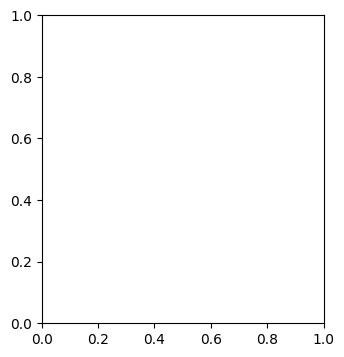

In [20]:
from collections import Counter

word_counts = Counter(word for tweet in processed_tweets for word in tweet)
word_freq = np.array([word_counts[word] for word in vocab])

epochs = 10
window_size = 3
num_negative_samples=3
# Training Loop
for epoch in range(epochs):
    for tweet in processed_tweets:
        for center_idx, center_word in enumerate(tweet):
            center_word_idx = word_to_idx[center_word]
            start = max(center_idx - window_size, 0)
            end = min(center_idx + window_size + 1, len(tweet))

            for context_idx in range(start, end):
                if center_idx == context_idx:
                    continue
                context_word_idx = word_to_idx[tweet[context_idx]]

                # Positive sample
                plot_words(('like', 'happy'))
                update_embeddings(center_word_idx, context_word_idx, 1)

                # Negative samples
                negative_samples = get_negative_samples(vocab_size, center_word_idx, num_negative_samples, word_freq)
                for negative_idx in negative_samples:
                    update_embeddings(center_word_idx, negative_idx, 0)

    # Normalize embeddings after each epoch
    main_embeddings = normalize_embeddings(main_embeddings)
    
    context_embeddings = normalize_embeddings(context_embeddings)
    # print(f"Epoch {epoch + 1}/{epochs} completed")
# plot_words(['like', 'happy'])



In [ ]:
import matplotlib.pyplot as plt

def plot_word_vectors(word_list, embeddings, word_to_idx):
    """
    Visualizes the vectors of given words in 2D space.
    
    Parameters:
        word_list (list): List of words to visualize.
        embeddings (numpy.ndarray): Embedding matrix.
        word_to_idx (dict): Mapping of words to their indices.
    """
    if len(word_list) > 2:
        raise ValueError("Please provide exactly two words for visualization.")
    
    # Extract vectors for the given words
    vectors = np.array([embeddings[word_to_idx[word]] for word in word_list])
    
    # Plot vectors in 2D space
    plt.figure(figsize=(8, 6))
    origin = [0, 0]
    for word, vector in zip(word_list, vectors):
        plt.quiver(
            *origin, vector[0], vector[1], scale=1, scale_units='xy', angles='xy',
            color=np.random.rand(3,), label=word
        )
        plt.text(vector[0] * 1.1, vector[1] * 1.1, word, fontsize=12, color='red')
    
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid()
    plt.legend()
    plt.title("Word Vector Visualization")
    plt.show()

# Example words to visualize (ensure they exist in your vocab)
words_to_visualize = ['unhappy', 'better']  # Replace with actual words from your vocabulary
plot_word_vectors(words_to_visualize, main_embeddings, word_to_idx)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Example embeddings (assuming main_embeddings is already populated)
# # Replace with actual embedding vectors during training
# main_embeddings = np.random.rand(100, 50)  # Example of 100 words with 50-dimensional vectors
# context_embeddings = np.random.rand(100, 50)

# # Choose two example words to visualize
# example_words = ["thanks", "happy"]  # Replace with actual words in your vocabulary
# example_indices = [word_to_idx[word] for word in example_words]

# # Get their embeddings
# example_vectors = main_embeddings[example_indices]

# # Reduce to 2D for visualization using PCA
# pca = PCA(n_components=2)
# reduced_vectors = pca.fit_transform(example_vectors)

# # Visualize the vectors
# plt.figure(figsize=(8, 6))
# for i, word in enumerate(example_words):
#     plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=word, s=100)
#     plt.text(reduced_vectors[i, 0] + 0.02, reduced_vectors[i, 1], word, fontsize=12)

# plt.title("Visualization of Word Embeddings")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.legend()
# plt.grid(True)
plt.show()
